# SHAP (Feature Selection)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


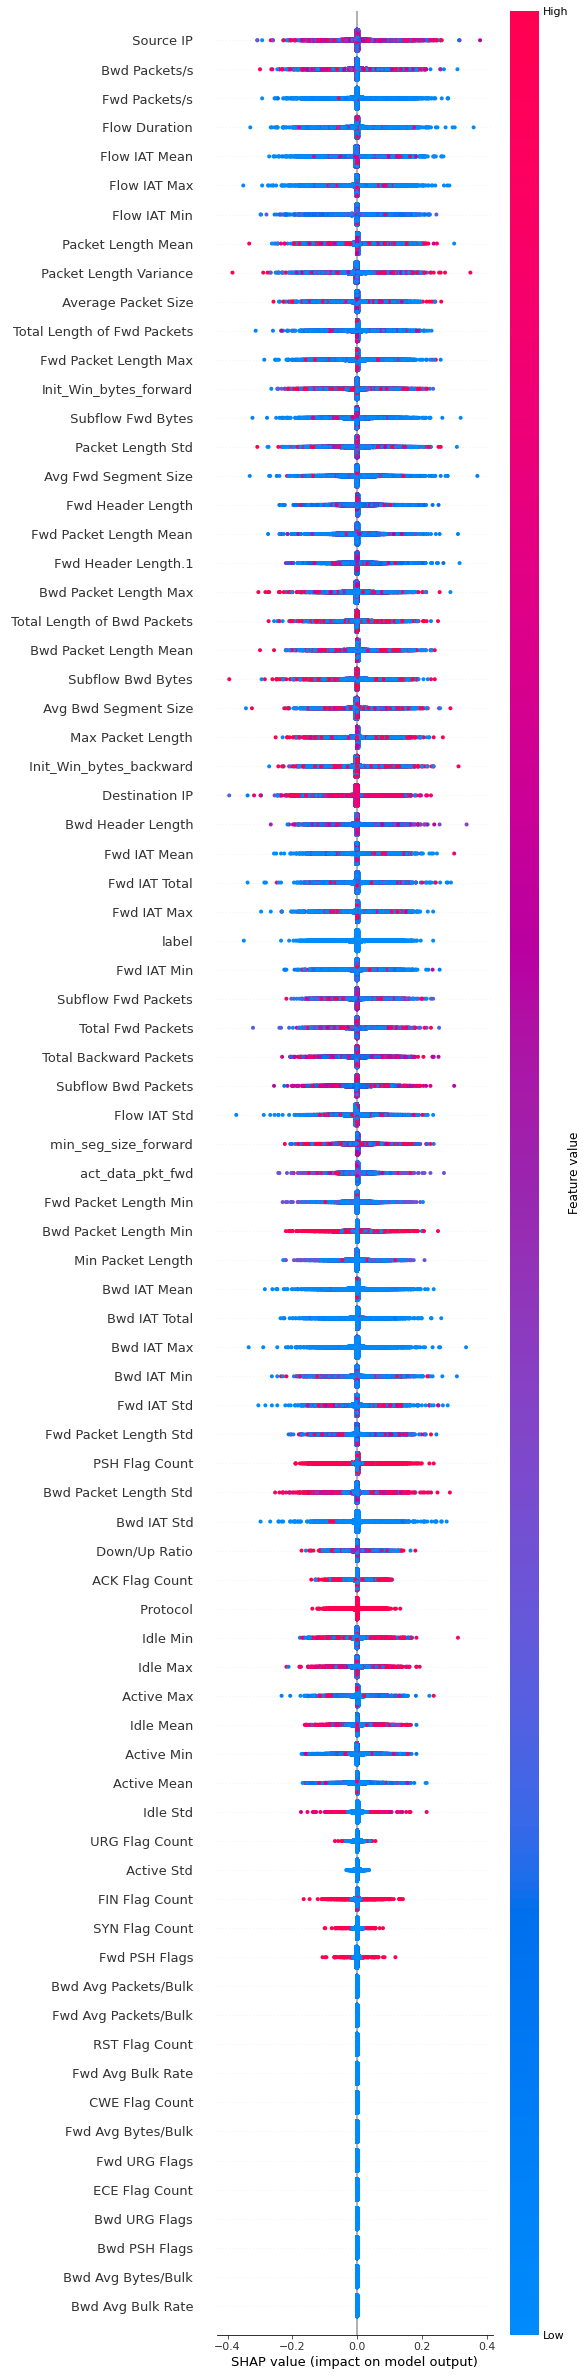

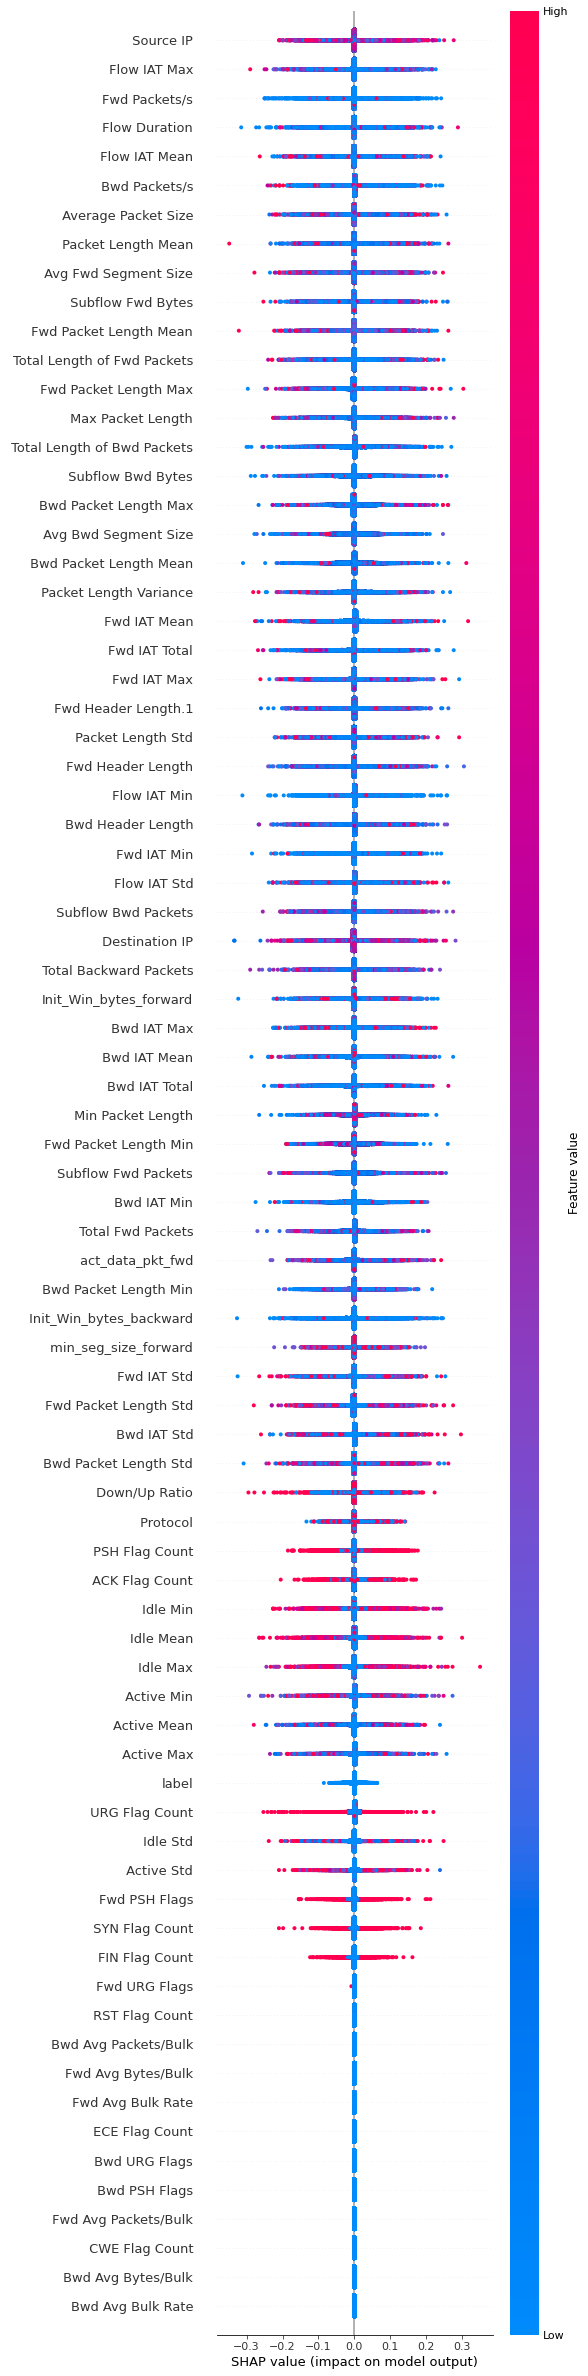

In [3]:
import pandas as pd
import shap
import pickle
import matplotlib.pyplot as plt
import numpy as np


X_test = pd.read_csv('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_all.csv', encoding="ISO-8859–1", dtype = str)
X_test = X_test.apply(pd.to_numeric)
X_test = X_test.astype(float)

# print(X_test.dtypes.to_string())


# filename_expl = './src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_explainer.sav'
filename = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_shapvalues_all.sav'


# load_explainer = pickle.load(open(filename_expl, 'rb'))
# print(load_explainer)

label_column = X_test["label"]
attack_indx = []
benign_indx = []
for i, x in enumerate(label_column):
    if (x == 1.0):
        attack_indx.append(i)
    elif (x == 0.0):
        benign_indx.append(i)

load_shap_values = pickle.load(open(filename, 'rb'))

shap.summary_plot(load_shap_values[attack_indx], feature_names = X_test.columns, max_display=X_test.shape[1])
shap.summary_plot(load_shap_values[benign_indx], feature_names = X_test.columns, max_display=X_test.shape[1])

In [4]:
# Feature importance
print("Avg shapley values for intrusions :")
print(np.sum(np.abs(load_shap_values[attack_indx].values), axis=0) / len(attack_indx))
print()
feature_order_attack = np.argsort(np.sum(np.abs(load_shap_values[attack_indx].values), axis=0))
feature_order_attack = [X_test.columns[i] for i in feature_order_attack][::-1]
print(feature_order_attack)

print()
print("**********")
print()

print("Avg shapley values for bengin :")
print(np.sum(np.abs(load_shap_values[benign_indx].values), axis=0) / len(benign_indx))
print()
feature_order_benign = np.argsort(np.sum(np.abs(load_shap_values[benign_indx].values), axis=0))
feature_order_benign = [X_test.columns[i] for i in feature_order_benign][::-1]
print(feature_order_benign)

Avg shapley values for intrusions :
[0.01087603 0.01526609 0.01540351 0.00761305 0.01069569 0.01579855
 0.01591626 0.01632101 0.01373181 0.01705698 0.01035427 0.01199902
 0.         0.01213003 0.0168008  0.01650997 0.00148333 0.00751466
 0.00815115 0.         0.01576221 0.0117672  0.01370348 0.00237694
 0.00776591 0.0031143  0.         0.01227532 0.01436392 0.01448252
 0.01381666 0.01382443 0.01448396 0.01485565 0.00765582 0.00772055
 0.00267912 0.01564485 0.01027848 0.01685333 0.         0.00791185
 0.         0.0153588  0.         0.01526564 0.00193992 0.0157396
 0.01541506 0.01614177 0.01505611 0.01638714 0.         0.01382881
 0.00863148 0.         0.01180927 0.         0.01294611 0.01580916
 0.01209592 0.01787909 0.01642573 0.01500383 0.01561298 0.01657834
 0.00147636 0.01151187 0.         0.01577142 0.         0.
 0.00746472 0.01277955 0.01524886 0.01244471 0.01206176 0.01559366
 0.01384499]

[' Source IP', ' Bwd Packets/s', 'Fwd Packets/s', ' Flow Duration', ' Flow IAT Mean', ' 

# Feature Selection

In [5]:
feature_selection_rate = 0.8

important_features = ['label', ' Source IP', ' Destination IP']
feature_order_attack = [x for x in feature_order_attack if x not in important_features]
feature_order_benign = [x for x in feature_order_benign if x not in important_features]

least_important_in_attack = feature_order_attack[int(feature_selection_rate * 76):]
least_important_in_benign = feature_order_benign[int(feature_selection_rate * 76):]

least_important = list(set(least_important_in_attack) & set(least_important_in_benign))

print(least_important)
print()
print("len(least_important) =", len(least_important))

sizeh = 76 - len(least_important)
print("sizeh =", sizeh)

['FIN Flag Count', ' RST Flag Count', ' Bwd Avg Bytes/Bulk', 'Fwd Avg Bytes/Bulk', ' SYN Flag Count', ' ECE Flag Count', ' Bwd URG Flags', ' Active Std', 'Fwd PSH Flags', ' Fwd Avg Bulk Rate', ' Fwd URG Flags', ' Bwd Avg Packets/Bulk', ' Bwd PSH Flags', ' CWE Flag Count', ' Fwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

len(least_important) = 16
sizeh = 60


# E-GraphSAGE

In [7]:
from dgl import from_networkx
import sklearn
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import numpy as np
from sklearn.metrics import confusion_matrix

import os
from sklearn.utils import shuffle

from dgl.data.utils import save_graphs

import shap
import matplotlib.pyplot as plt

#constante
size_embedding = 152
nb_batch = 5

# Accuracy --------------------------------------------------------------------
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()
# -----------------------------------------------------------------------------

# ------------------------------------------ Model Architecture -----------------------------------------------------------------

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        x = th.cat([edges.src['h'], edges.data['h']], 2)
        y = self.W_msg(x)
        return {'m': y}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Line 4 of algorithm 1 : update all because we are using a full neighborhood sampling and not a k-hop neigh sampling
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Line 5 of algorithm 1
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, size_embedding, activation))
        self.layers.append(SAGELayer(size_embedding, edim, size_embedding, activation)) ##
        self.layers.append(SAGELayer(size_embedding, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):

        for i, layer in enumerate(self.layers):
            #nf = 'weights'+str(i)+'.txt'
            #sourceFile = open(nf, 'w')
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)
        # Return a list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        v = th.cat([h_u, h_v], 1)
        score = self.W(v)
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            # Update the features of the specified edges by the provided function
            # DGLGraph.apply_edges(func, edges='__ALL__', etype=None, inplace=False)
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class GPreprocessing():
    def __init__(self):
        self.encoder_cols = [x for x in [' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'] if x not in least_important]
        if (len(self.encoder_cols) != 0):
            self.encoder1 = ce.TargetEncoder(cols = self.encoder_cols)
        self.scaler1 = StandardScaler()
        super().__init__()

    def train(self, data1):
        # Preprocessing and creation of the h attribute
        label1 = data1['label']
        if (len(self.encoder_cols) != 0):
            self.encoder1.fit(data1, label1)
            data1 = self.encoder1.transform(data1)
        # scaler (normalization)
        # Manipulate flow content (all columns except : label, Source IP & Destination IP)
        cols_to_norm1 = list(set(list(data1.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
        data1[cols_to_norm1] = self.scaler1.fit_transform(data1[cols_to_norm1])
        ## Create the h attribute that will contain the content of our flows
        data1['h'] = data1[ cols_to_norm1 ].values.tolist()
        # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
        data1.drop(columns = cols_to_norm1, inplace = True)
        # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
        data1 = data1.reindex(columns=columns_titles)

        # Graph construction #################################################
        G1 = nx.from_pandas_edgelist(data1, " Source IP", " Destination IP", ['h','label'], create_using=nx.MultiDiGraph())
        # G1 = G1.to_directed()
        G1 = from_networkx(G1,edge_attrs=['h','label'] )
        G1.ndata['h'] = th.ones(G1.num_nodes(), G1.edata['h'].shape[1])
        G1.edata['train_mask'] = th.ones(len(G1.edata['h']), dtype=th.bool)
        G1.ndata['h'] = th.reshape(G1.ndata['h'], (G1.ndata['h'].shape[0], 1, G1.ndata['h'].shape[1]))
        G1.edata['h'] = th.reshape(G1.edata['h'], (G1.edata['h'].shape[0], 1, G1.edata['h'].shape[1]))
        return G1

    def test(self, data1):
        if (len(self.encoder_cols) != 0):
            data1 = self.encoder1.transform(data1)
        cols_to_norm1 = list(set(list(data1.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
        data1[cols_to_norm1] = self.scaler1.transform(data1[cols_to_norm1])
        data1['h'] = data1[ cols_to_norm1 ].values.tolist()
        data1.drop(columns = cols_to_norm1, inplace = True)
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
        data1 = data1.reindex(columns=columns_titles)

        # Graph construction #################################################
        G1_test = nx.from_pandas_edgelist(data1, " Source IP", " Destination IP", ['h','label'], create_using=nx.MultiDiGraph())
        # G1_test = G1_test.to_directed()
        G1_test = from_networkx(G1_test,edge_attrs=['h','label'] )
        # G1.ndata['h'].shape[2] = sizeh = 76
        G1_test.ndata['feature'] = th.ones(G1_test.num_nodes(), sizeh)
        G1_test.ndata['feature'] = th.reshape(G1_test.ndata['feature'], (G1_test.ndata['feature'].shape[0], 1, G1_test.ndata['feature'].shape[1]))
        G1_test.edata['h'] = th.reshape(G1_test.edata['h'], (G1_test.edata['h'].shape[0], 1, G1_test.edata['h'].shape[1]))
        return G1_test


class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.preprocessing = GPreprocessing()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, nbclasses)

    def train(self, data1, epochs):
        G1 = self.preprocessing.train(data1)
        G1 = G1.to('cuda:0')
        from sklearn.utils import class_weight
        class_weights1 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1.edata['label'].cpu().numpy()),
                                                        y = G1.edata['label'].cpu().numpy())
        class_weights1 = th.FloatTensor(class_weights1).cuda()
        criterion1 = nn.CrossEntropyLoss(weight = class_weights1)

        nfeats = G1.ndata['h']
        efeats = G1.edata['h']

        edge_label1 = G1.edata['label']
        train_mask1 = G1.edata['train_mask']

        for epoch in range(1, epochs):
            h = self.gnn(G1, nfeats, efeats).cuda()
            pred1 = self.pred(G1, h).cuda()
            loss = criterion1(pred1[train_mask1], edge_label1[train_mask1])
            opt.zero_grad()
            loss.backward()
            opt.step()
            # if epoch % 10 == 0:
            #     print('Training acc:', compute_accuracy(pred1[train_mask1], edge_label1[train_mask1]), loss)

        h = self.gnn(G1, nfeats, efeats).cuda()
        pred1 = self.pred(G1, h).cuda()

        pred1 = pred1.argmax(1)
        pred1 = th.Tensor.cpu(pred1).detach().numpy()
        edge_label1 = th.Tensor.cpu(edge_label1).detach().numpy()
        return pred1, edge_label1

    def predict(self, data1):
        G1_test = self.preprocessing.test(data1)
        G1_test = G1_test.to('cuda:0')
        actual1 = G1_test.edata.pop('label')
        node_features_test1 = G1_test.ndata['feature']
        edge_features_test1 = G1_test.edata['h']
        h = self.gnn(G1_test, node_features_test1, edge_features_test1).cuda()
        test_pred1 = self.pred(G1_test, h)

        test_pred1 = test_pred1.argmax(1)
        test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()
        actual1 = th.Tensor.cpu(actual1).detach().numpy()
        return test_pred1, actual1

    def xai_predict(self, data1):
        G1_test = self.preprocessing.test(data1)
        G1_test = G1_test.to('cuda:0')
        node_features_test1 = G1_test.ndata['feature']
        edge_features_test1 = G1_test.edata['h']
        h = self.gnn(G1_test, node_features_test1, edge_features_test1).cuda()
        test_pred1 = self.pred(G1_test, h)

        test_pred1 = test_pred1.argmax(1)
        test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()
        return test_pred1

    # def forward(self, g, nfeats, efeats):
        # h = self.gnn(g, nfeats, efeats)
        # # h = list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
        # return self.pred(g, h)

# -------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------- MAIN -----------------------------------------------------------

#Data
nbclasses =  2

# To test
sizeh = 76
least_important = []


# Model *******************************************************************************************
# G1.ndata['h'].shape[2] = sizeh = 76 dans ANIDS
# model1 = Model(G1.ndata['h'].shape[2], size_embedding, G1.ndata['h'].shape[2], F.relu, 0.2).cuda()

print("sizeh =", sizeh)

model1 = Model(sizeh, size_embedding, sizeh, F.relu, 0.2).cuda()
opt = th.optim.Adam(model1.parameters())


path, dirs, files = next(os.walk("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/GlobalDataset/Splitted/"))
file_count = len(files)

for nb_files in range(file_count):
    data1 = pd.read_csv(f'{path}{files[nb_files]}', encoding="ISO-8859–1", dtype = str)

    print(f'{files[nb_files]} ++++++++++++++++++++++++++++++++++++++++++++++')
    print("nb total instances in the file : ", len(data1.values))

    print("++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++")

    # Delete two columns (U and V in the excel)
    cols = list(set(list(data1.columns )) - set(list(['Flow Bytes/s',' Flow Packets/s'])) )
    data1 = data1[cols]
    
    # Feature Selection +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    cols = list(set(list(data1.columns )) - set(least_important))
    data1 = data1[cols]
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    # Mise en forme des noeuds
    data1[' Source IP'] = data1[' Source IP'].apply(str)
    data1[' Source Port'] = data1[' Source Port'].apply(str)
    data1[' Destination IP'] = data1[' Destination IP'].apply(str)
    data1[' Destination Port'] = data1[' Destination Port'].apply(str)
    data1[' Source IP'] = data1[' Source IP'] + ':' + data1[' Source Port']
    data1[' Destination IP'] = data1[' Destination IP'] + ':' + data1[' Destination Port']

    data1.drop(columns=['Flow ID',' Source Port',' Destination Port',' Timestamp'], inplace=True)

    # -------------------- ????????????????????????????????????????? --------------------
    # simply do : nom = list(data1[' Label'].unique())
    nom = []
    nom = nom + [data1[' Label'].unique()[0]]
    for i in range(1, len(data1[' Label'].unique())):
        nom = nom + [data1[' Label'].unique()[i]]

    nom.insert(0, nom.pop(nom.index('BENIGN')))

    # Naming the two classes BENIGN {0} / Any Intrusion {1}
    data1[' Label'].replace(nom[0], 0,inplace = True)
    for i in range(1,len(data1[' Label'].unique())):
        data1[' Label'].replace(nom[i], 1,inplace = True)

    ##################### LABELS FREQ #######################################
    print()
    print("labels freq after changing labels to binary")
    counts = list(data1[' Label'].value_counts().to_dict().items())
    for j, x in enumerate(counts):
        x = list(x)
        x[1] = x[1] / len(data1)
        counts[j] = x
    print({f'{files[nb_files]}' : counts})
    ##############################################################################

    data1.rename(columns={" Label": "label"},inplace = True)
    label1 = data1.label
    data1.drop(columns=['label'],inplace = True)

    # ******** At this step data1 contains only the data without label column
    # ******** The label column is stored in the label variale

    # split train and test
    data1 =  pd.concat([data1, label1], axis=1) # ??????? WHY ?

    # -------------------- ????????????????????????????????????????? --------------------
    # X will contain the label column due to the concatination made earlier !!
    X1_train, X1_test, y1_train, y1_test = train_test_split(data1, label1, test_size=0.3, random_state=123, stratify= label1)

    # At this step we duplicated the least populated classes in the Train Set
    # 2nd step : Create the mini batches
    a = b = mean_macro_f1 = 0
    for batch in range(1, nb_batch + 1):
        print(f"+++++++++++++++++ Batch {batch} ++++++++++++++++")
        a = b
        b = int(len(X1_train) / nb_batch) * batch
        if batch == nb_batch :
            b = len(X1_train)
        # The batch :
        X1_train_batched = X1_train.iloc[a:b]
        y1_train_batched = X1_train_batched['label']

        pred1, edge_label1 = model1.train(X1_train_batched, 1000)

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1, pred1))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1, pred1, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1, pred1, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1, pred1, labels=[0,1]))

    # ------------------------------------------------ Test ---------------------------------------------------------------------
    print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
    print("nb Test instances : ", len(X1_test.values))

    test_pred1, actual1 = model1.predict(X1_test)
    print(test_pred1)
    print(len(test_pred1))
    print(len(actual1))

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
    print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

sizeh = 76
CIC-IDS-2017-Dataset4.csv ++++++++++++++++++++++++++++++++++++++++++++++
nb total instances in the file :  460167
++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++

labels freq after changing labels to binary
{'CIC-IDS-2017-Dataset4.csv': [[0, 0.7582073464633492], [1, 0.24179265353665083]]}
+++++++++++++++++ Batch 1 ++++++++++++++++
Train metrics :
Accuracy :  0.9920370054173199
Precision :  0.9684256324196656
Recall :  0.9996791992814064
f1_score :  0.9838042620363062
+++++++++++++++++ Batch 2 ++++++++++++++++
Train metrics :
Accuracy :  0.990500287164522
Precision :  0.9641272189349113
Recall :  0.9980857580398163
f1_score :  0.9808126410835215
+++++++++++++++++ Batch 3 ++++++++++++++++
Train metrics :
Accuracy :  0.9905468543843038
Precision :  0.9649436263939375
Recall :  0.9974525538148007
f1_score :  0.980928819716281
+++++++++++++++++ Batch 4 ++++++++++++++++
Train metrics :
Accuracy :  0.9915558108129084
Precision :  0.9677115987460815
Recall :  0.9

In [9]:
print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
print("nb Test instances : ", len(X1_test.values))

test_pred1 = model1.xai_predict(X1_test)
print(test_pred1)
print(len(test_pred1))
print(len(actual1))

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

print("****************")

test_pred1 = model1.xai_predict(X1_test)
print(test_pred1)
print(len(test_pred1))
print(len(actual1))

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
print("nb Test instances : ", len(X1_test.values))

test_pred1 = model1.xai_predict(X1_test)
print(test_pred1)
print(len(test_pred1))
print(len(actual1))

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

print("****************")

test_pred1 = model1.xai_predict(X1_test)
print(test_pred1)
print(len(test_pred1))
print(len(actual1))

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++
nb Test instances :  138050
[1 1 0 ... 0 0 0]
138050
138050
Metrics : 
Accuracy :  0.9906917783411807
Precision :  0.968284450651769
Recall :  0.9941744092253458
f1_score :  0.9810586518477027
****************
[1 1 0 ... 0 0 0]
138050
138050
Metrics : 
Accuracy :  0.990996015936255
Precision :  0.9682415155741516
Recall :  0.9955187763271891
f1_score :  0.9816907009972161
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++
nb Test instances :  138050
[1 1 0 ... 0 0 0]
138050
138050
Metrics : 
Accuracy :  0.9913437160449112
Precision :  0.9692933992439663
Recall :  0.9958473993965286
f1_score :  0.982390993619498
****************
[1 1 0 ... 0 0 0]
138050
138050
Metrics : 
Accuracy :  0.9909597971749367
Precision :  0.9685364506092065
Recall :  0.9950407791354225
f1_score :  0.9816097374082697
++++++++++++++++++++++++++++++++++++++++++++++++++++++

# XAI : SHAP

In [7]:
X1_test1 = X1_test.loc[X1_test['label'] == 1].iloc[0:5000]
X1_test0 = X1_test.loc[X1_test['label'] == 0].iloc[0:5000]
X1_test = pd.concat([X1_test1, X1_test0], ignore_index = True)

In [8]:
print(X1_test)
print(list(set(list(X1_test.columns))))

# IP Mapping *************************************************************************
# We do tha mapping of test set only because its faster and it will generate totally new nodes from the train set
test_res = set()

for x in list(X1_test[' Source IP']) :
    test_res.add(x)
for x in list(X1_test[' Destination IP']) :
    test_res.add(x)

test_re = {}
cpt = 0.0
print("type(cpt)", type(cpt))
for x in test_res:
    test_re[x] = cpt
    cpt += 1.0

print("LAST type(cpt)", type(cpt))
print()

print(X1_test)
X1_test = X1_test.replace({' Source IP': test_re})
print("X1_test Source IP mapped")
X1_test = X1_test.replace({' Destination IP': test_re})
print("X1_test Destination IP mapped")
print(X1_test)
print()
# ***********************************************************************************

cols_to_norm1 = list(set(list(data1.iloc[:, :].columns )) - set(list([' Source IP', ' Destination IP'])))

X1_test[cols_to_norm1] = X1_test[cols_to_norm1].apply(pd.to_numeric)
X1_test[cols_to_norm1] = X1_test[cols_to_norm1].astype(float)

print()
print(X1_test.dtypes)

print()
print(X1_test.dtypes.to_string())

print("----------")
print(len(X1_test.columns))

X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_shap_feature_selection.csv', sep=',', index = False)

      Bwd IAT Min  Flow IAT Std  Fwd Packet Length Std  Fwd Packet Length Max  \
0              14      2.89E+07            122.6730071                    304   
1               0             0                      0                      0   
2              86      1.95E+07            150.4298603                    398   
3               3    634733.525            141.9141327                    640   
4               0    4334353.54                      0                      6   
...           ...           ...                    ...                    ...   
9995            3    149428.224            93.75069231                    378   
9996            0   2384173.025             20.1246118                     46   
9997            1   260835.6104            343.6516506                   1381   
9998            0             0            21.92031022                     31   
9999            3   4402207.597            240.6169154                    867   

      Avg Fwd Segment Size 

X1_test Source IP mapped
X1_test Destination IP mapped
      Bwd IAT Min  Flow IAT Std  Fwd Packet Length Std  Fwd Packet Length Max  \
0              14      2.89E+07            122.6730071                    304   
1               0             0                      0                      0   
2              86      1.95E+07            150.4298603                    398   
3               3    634733.525            141.9141327                    640   
4               0    4334353.54                      0                      6   
...           ...           ...                    ...                    ...   
9995            3    149428.224            93.75069231                    378   
9996            0   2384173.025             20.1246118                     46   
9997            1   260835.6104            343.6516506                   1381   
9998            0             0            21.92031022                     31   
9999            3   4402207.597            240.6169154

In [ ]:
# XAI ######################
explainer = shap.Explainer(model1.xai_predict, X1_test)
shap_values = explainer(X1_test)

import pickle
filename_expl = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_explainer_shap_feature_selection.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))
filename = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_shapvalues_shap_feature_selection.sav'
pickle.dump(shap_values, open(filename, 'wb'))

print("explainer saved with pickle successfully")

# Explanation

## Graph analysis

In [1]:
import pandas as pd

# X_test = pd.read_csv('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_shap_feature_selection.csv', encoding="ISO-8859–1", dtype = str)
X_test = pd.read_csv('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/Test_shap_feature_selection5000_x_train.csv', encoding="ISO-8859–1", dtype = str)
X_test = X_test.apply(pd.to_numeric)
X_test = X_test.astype(float)

print(X_test.columns)
print(len(X_test))
print(len(X_test.columns))

Index([' Flow Duration', ' Active Std', ' act_data_pkt_fwd', ' Bwd Packets/s',
       ' Max Packet Length', ' RST Flag Count', ' Fwd IAT Mean',
       ' Fwd URG Flags', ' ACK Flag Count', ' min_seg_size_forward',
       'Fwd PSH Flags', ' Packet Length Variance', ' Bwd IAT Std',
       ' Fwd Packet Length Max', ' URG Flag Count', 'Fwd Avg Bytes/Bulk',
       ' Bwd IAT Mean', ' Packet Length Mean', ' Flow IAT Max', ' Fwd IAT Std',
       ' Flow IAT Std', 'Idle Mean', ' Fwd Header Length.1', ' Idle Std',
       ' PSH Flag Count', 'Fwd Packets/s', 'Total Length of Fwd Packets',
       'Fwd IAT Total', ' Avg Fwd Segment Size', ' Fwd Packet Length Mean',
       'Subflow Fwd Packets', ' Total Length of Bwd Packets',
       ' Bwd Packet Length Min', 'Bwd Avg Bulk Rate', 'Bwd IAT Total',
       ' Subflow Fwd Bytes', ' Bwd Avg Packets/Bulk', ' Destination IP',
       ' Packet Length Std', ' Bwd Packet Length Mean', ' Idle Min',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Fwd Packet 

In [2]:
import networkx as nx
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

X1_test = X_test

print("nb Test instances : ", len(X1_test.values))

encoder1 = ce.TargetEncoder(cols=[' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'])
encoder1.fit(X1_test, X1_test['label'])
X1_test = encoder1.transform(X1_test)
# X1_test = encoder1.transform(X1_test)

scaler1 = StandardScaler()
cols_to_norm1 = list(set(list(X1_test.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
X1_test[cols_to_norm1] = scaler1.fit_transform(X1_test[cols_to_norm1])
# X1_test[cols_to_norm1] = scaler1.transform(X1_test[cols_to_norm1])

X1_test['h'] = X1_test[ cols_to_norm1 ].values.tolist()
X1_test.drop(columns = cols_to_norm1, inplace = True)

# Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
X1_test = X1_test.reindex(columns=columns_titles)

G1_test = nx.from_pandas_edgelist(X1_test, " Source IP", " Destination IP", ['h','label'],create_using=nx.MultiGraph())

print(G1_test)
print("nb connected component =", len(list(nx.connected_components(G1_test))))

nb Test instances :  5000
MultiGraph with 6035 nodes and 5000 edges
nb connected component = 1142


In [3]:
print(len(list(nx.connected_components(G1_test))[0]))

data_bar = dict()
for i, x in enumerate(list(nx.connected_components(G1_test))):
    data_bar[f'{i}'] = len(x)

print(len(data_bar))
data_bar = dict(sorted(data_bar.items(), key=lambda x:x[1], reverse=True))

2083
1142


In [4]:
from itertools import islice

data_bar10 = dict(islice(data_bar.items(), 10))
print("10-big connected components =", data_bar10)

10-big connected components = {'0': 2083, '221': 755, '226': 329, '4': 56, '40': 24, '265': 22, '446': 21, '27': 18, '262': 18, '298': 16}


In [5]:
# print(dict(G1_test.degree))
node_bar = dict(sorted(dict(G1_test.degree).items(), key=lambda x:x[1], reverse=True))

# print(node_bar)

from itertools import islice

node_bar10 = dict(islice(node_bar.items(), 10))
print("10-max nodes degrees =", node_bar10)

10-max nodes degrees = {1081.0: 1787, 13.0: 748, 6101.0: 349, 8986.0: 56, 2197.0: 39, 456.0: 21, 9960.0: 20, 6103.0: 17, 7560.0: 15, 415.0: 13}


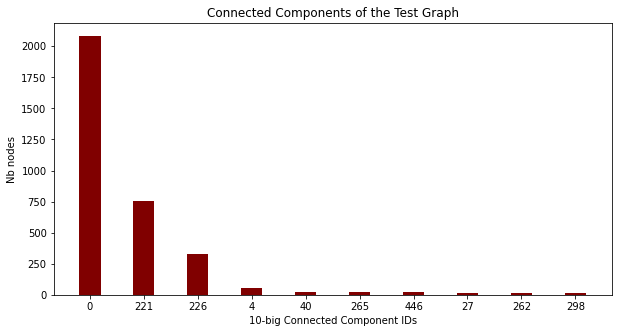

10-big connected components = {'0': 2083, '221': 755, '226': 329, '4': 56, '40': 24, '265': 22, '446': 21, '27': 18, '262': 18, '298': 16}
MultiGraph with 6035 nodes and 5000 edges


In [10]:
import numpy as np
import matplotlib.pyplot as plt

connected_components = list(data_bar10.keys())
nb_nodes = list(data_bar10.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(connected_components, nb_nodes, color ='maroon',
        width = 0.4)
 
plt.xlabel("10-big Connected Component IDs")
plt.ylabel("Nb nodes")
plt.title("Connected Components of the Test Graph")
plt.show()
print("10-big connected components =", data_bar10)
print(G1_test)

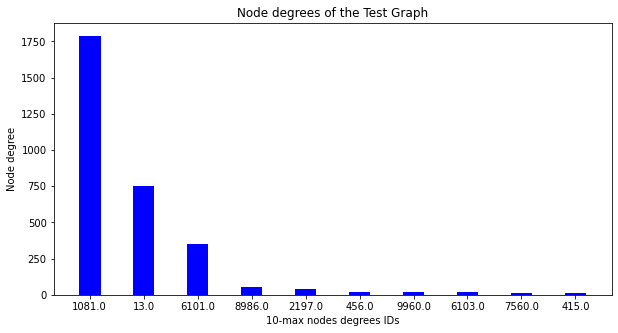

10-max nodes degrees = {1081.0: 1787, 13.0: 748, 6101.0: 349, 8986.0: 56, 2197.0: 39, 456.0: 21, 9960.0: 20, 6103.0: 17, 7560.0: 15, 415.0: 13}
MultiGraph with 6035 nodes and 5000 edges


In [9]:
import numpy as np
import matplotlib.pyplot as plt

node_id = list(map(str, list(node_bar10.keys()))) 
node_degree = list(node_bar10.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(node_id, node_degree, color ='blue',
        width = 0.4)
 
plt.xlabel("10-max nodes degrees IDs")
plt.ylabel("Node degree")
plt.title("Node degrees of the Test Graph")
plt.show()
print("10-max nodes degrees =", node_bar10)
print(G1_test)

## SHAP Explanations

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


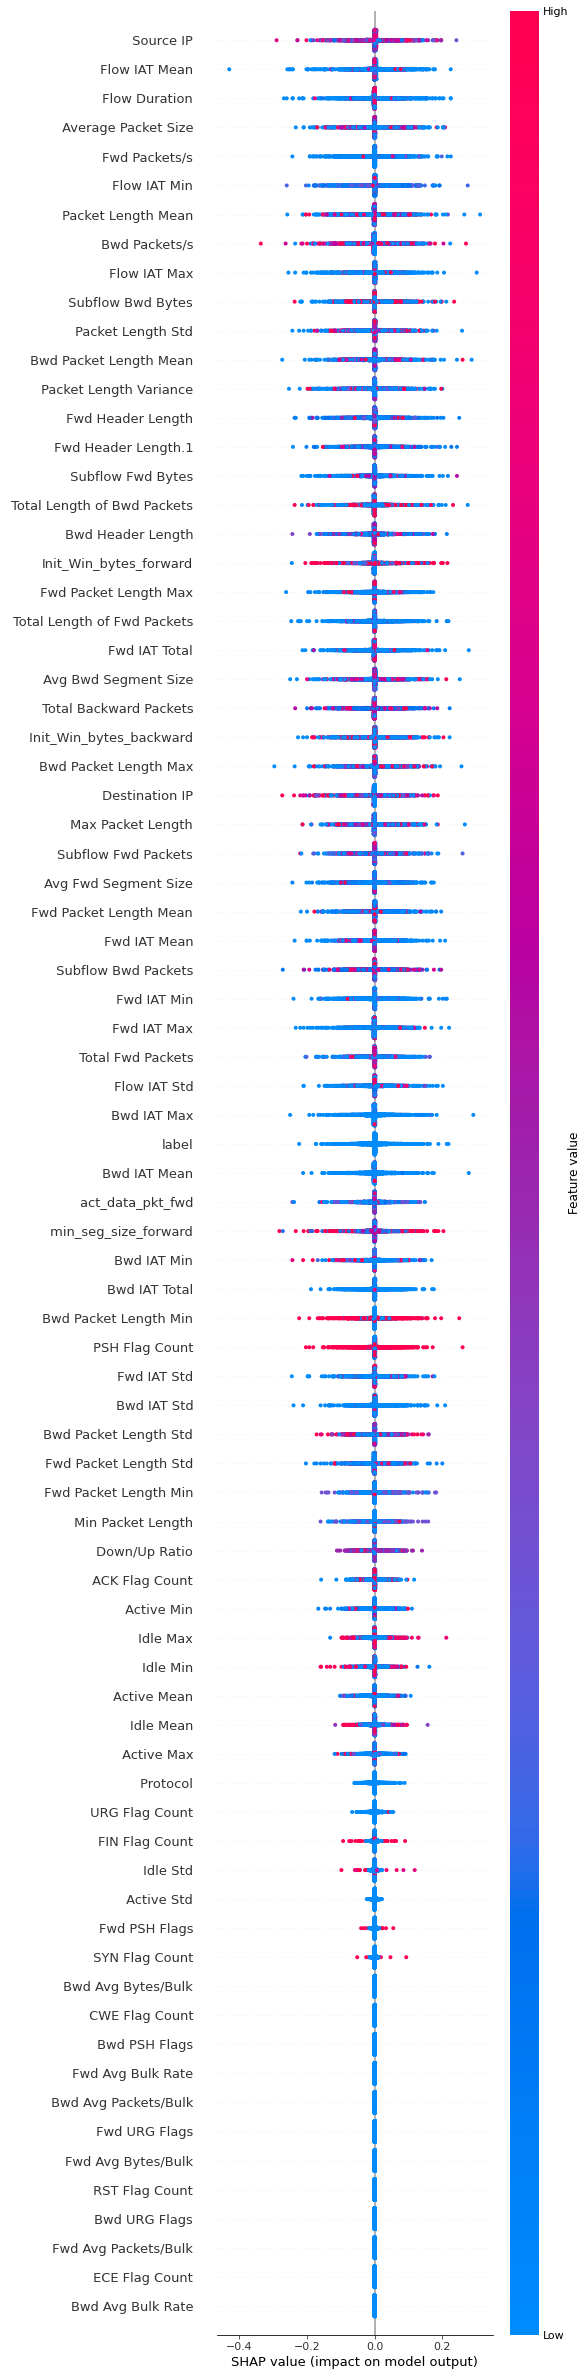

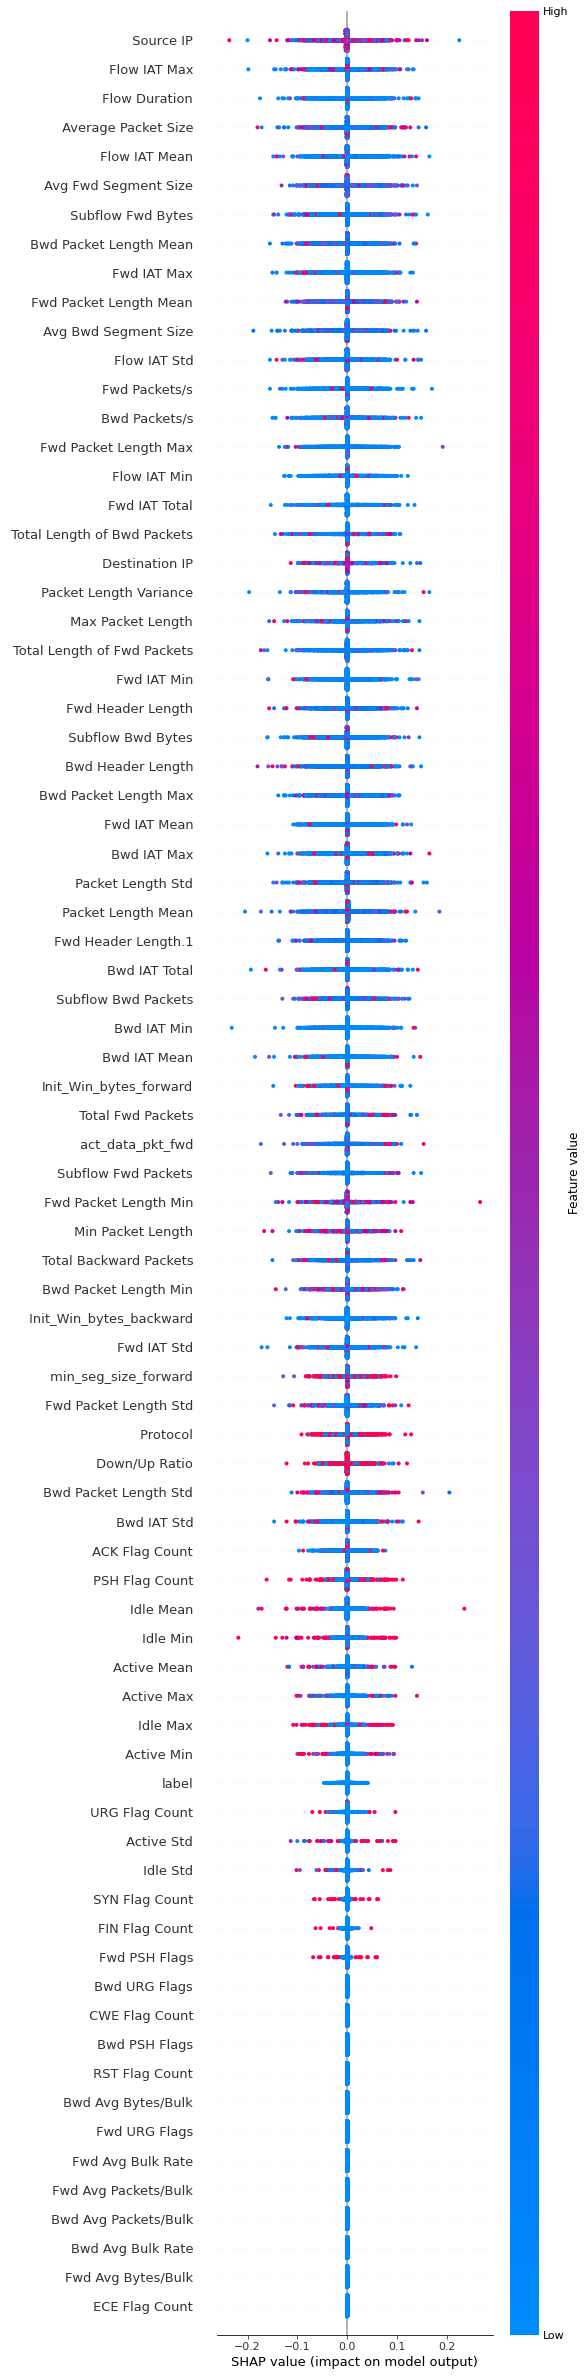

In [8]:
import shap
import pickle
import matplotlib.pyplot as plt
import numpy as np


# filename_expl = './src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_explainer.sav'
filename = '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/src/GNN_Model1/XP_CICIDS2017/XAI/SHAP_SAVED/GNN_SHAP_shapvalues_shap_feature_selection5000_x_train.sav'


# load_explainer = pickle.load(open(filename_expl, 'rb'))
# print(load_explainer)

label_column = X_test["label"]
attack_indx = []
benign_indx = []
for i, x in enumerate(label_column):
    if (x == 1.0):
        attack_indx.append(i)
    elif (x == 0.0):
        benign_indx.append(i)

load_shap_values = pickle.load(open(filename, 'rb'))

shap.summary_plot(load_shap_values[attack_indx], feature_names = X_test.columns, max_display=X_test.shape[1])
shap.summary_plot(load_shap_values[benign_indx], feature_names = X_test.columns, max_display=X_test.shape[1])

In [11]:
# Feature importance
print("Avg shapley values for intrusions :")
print(np.sort(np.sum(np.abs(load_shap_values[attack_indx].values), axis=0) / len(attack_indx))[::-1])
print()
feature_order_attack = np.argsort(np.sum(np.abs(load_shap_values[attack_indx].values), axis=0))
feature_order_attack_order = [X_test.columns[i] for i in feature_order_attack][::-1]
print(feature_order_attack_order)

print()
print("**********")
print()

print("Avg shapley values for bengin :")
print(np.sort(np.sum(np.abs(load_shap_values[benign_indx].values), axis=0) / len(benign_indx))[::-1])
print()
feature_order_benign = np.argsort(np.sum(np.abs(load_shap_values[benign_indx].values), axis=0))
feature_order_benign_order = [X_test.columns[i] for i in feature_order_benign][::-1]
print(feature_order_benign_order)

Avg shapley values for intrusions :
[0.02180067 0.02052    0.02026733 0.02016933 0.02006267 0.01985467
 0.01973133 0.01966867 0.01962133 0.01960333 0.01953267 0.01950733
 0.019436   0.01929867 0.01919    0.01912    0.01864067 0.01853
 0.018506   0.01842333 0.01832867 0.01832133 0.01819    0.01815
 0.01804267 0.018008   0.017916   0.017816   0.01772933 0.01759067
 0.01747133 0.01734733 0.017146   0.01707    0.017042   0.01652933
 0.01648667 0.01607133 0.01591467 0.01589467 0.01537933 0.01531
 0.01507933 0.01464667 0.01394933 0.01391867 0.01380667 0.01308467
 0.012442   0.01239133 0.01227933 0.01183933 0.010662   0.009664
 0.008842   0.00855067 0.00832333 0.00823933 0.00814267 0.00778933
 0.006976   0.00469333 0.00234733 0.00212267 0.001638   0.001384
 0.001314   0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]

[' Source IP', ' Flow IAT Mean', ' Flow Duration', ' Average Packet Size', 'Fwd Packets/s', ' Flow IAT Min',

(-1000000.0, 95610000.0)

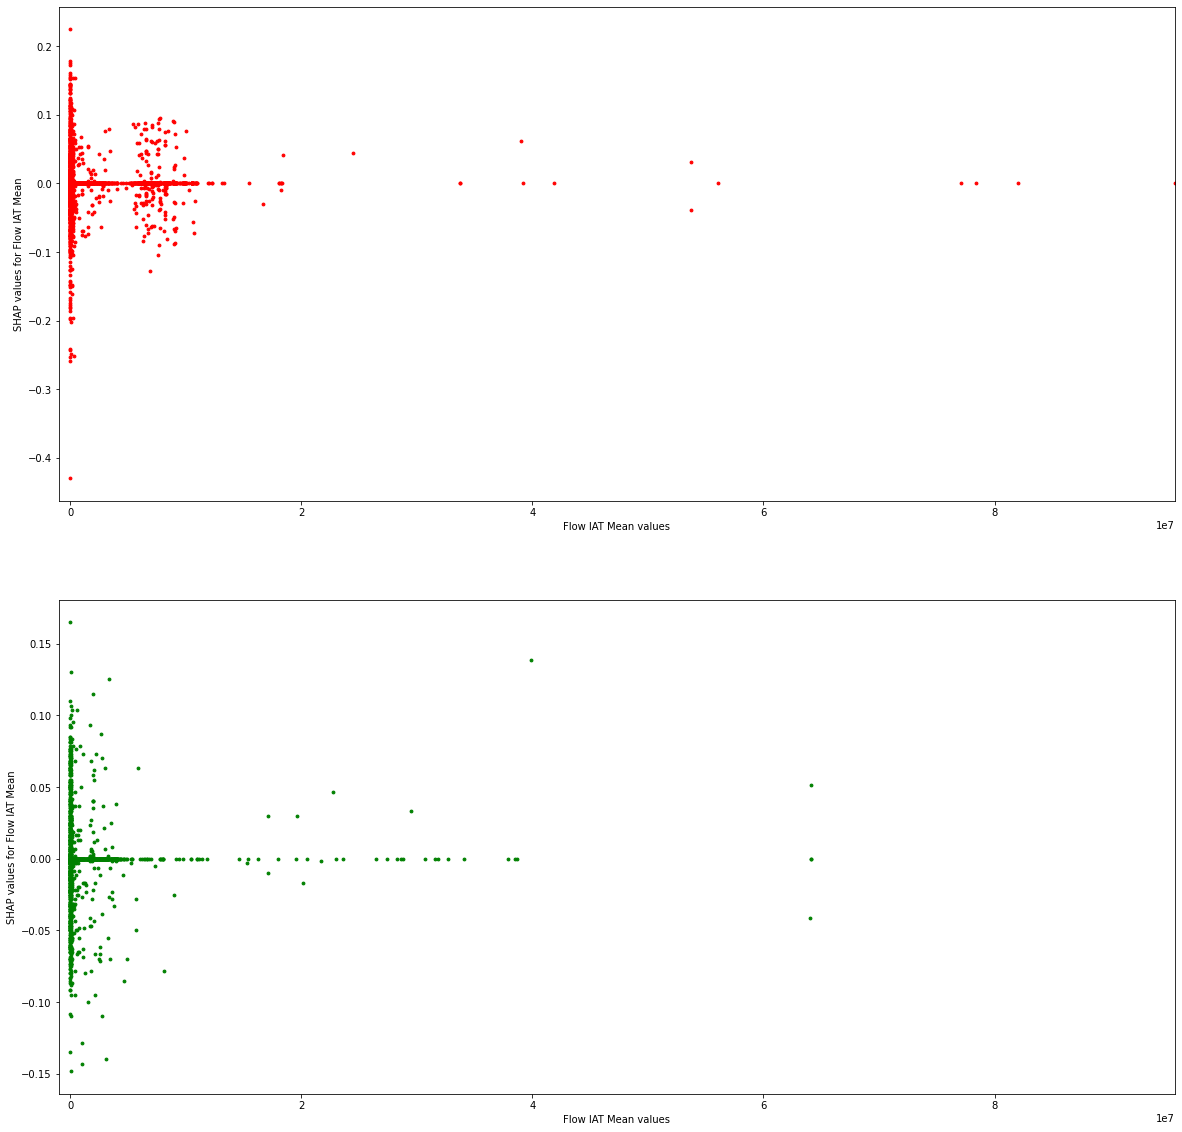

In [12]:
import matplotlib.pyplot as plt

# data = edge features
# values = shap values

fig, ax = plt.subplots(2, figsize=(20, 20))
ax[0].scatter(load_shap_values[attack_indx," Flow IAT Mean"].data, load_shap_values[attack_indx," Flow IAT Mean"].values, color = "r", marker = "o", s = 8)
ax[0].set_xlabel("Flow IAT Mean values")
ax[0].set_ylabel("SHAP values for Flow IAT Mean")
ax[0].set_xlim([-1000000, max(max(load_shap_values[attack_indx," Flow IAT Mean"].data), max(load_shap_values[benign_indx," Flow IAT Mean"].data))+10000])

ax[1].scatter(load_shap_values[benign_indx," Flow IAT Mean"].data, load_shap_values[benign_indx," Flow IAT Mean"].values, color = "g", marker = "o", s = 8)
ax[1].set_xlabel("Flow IAT Mean values")
ax[1].set_ylabel("SHAP values for Flow IAT Mean")
ax[1].set_xlim([-1000000, max(max(load_shap_values[attack_indx," Flow IAT Mean"].data), max(load_shap_values[benign_indx," Flow IAT Mean"].data))+10000])

(-1000000.0, 119010000.0)

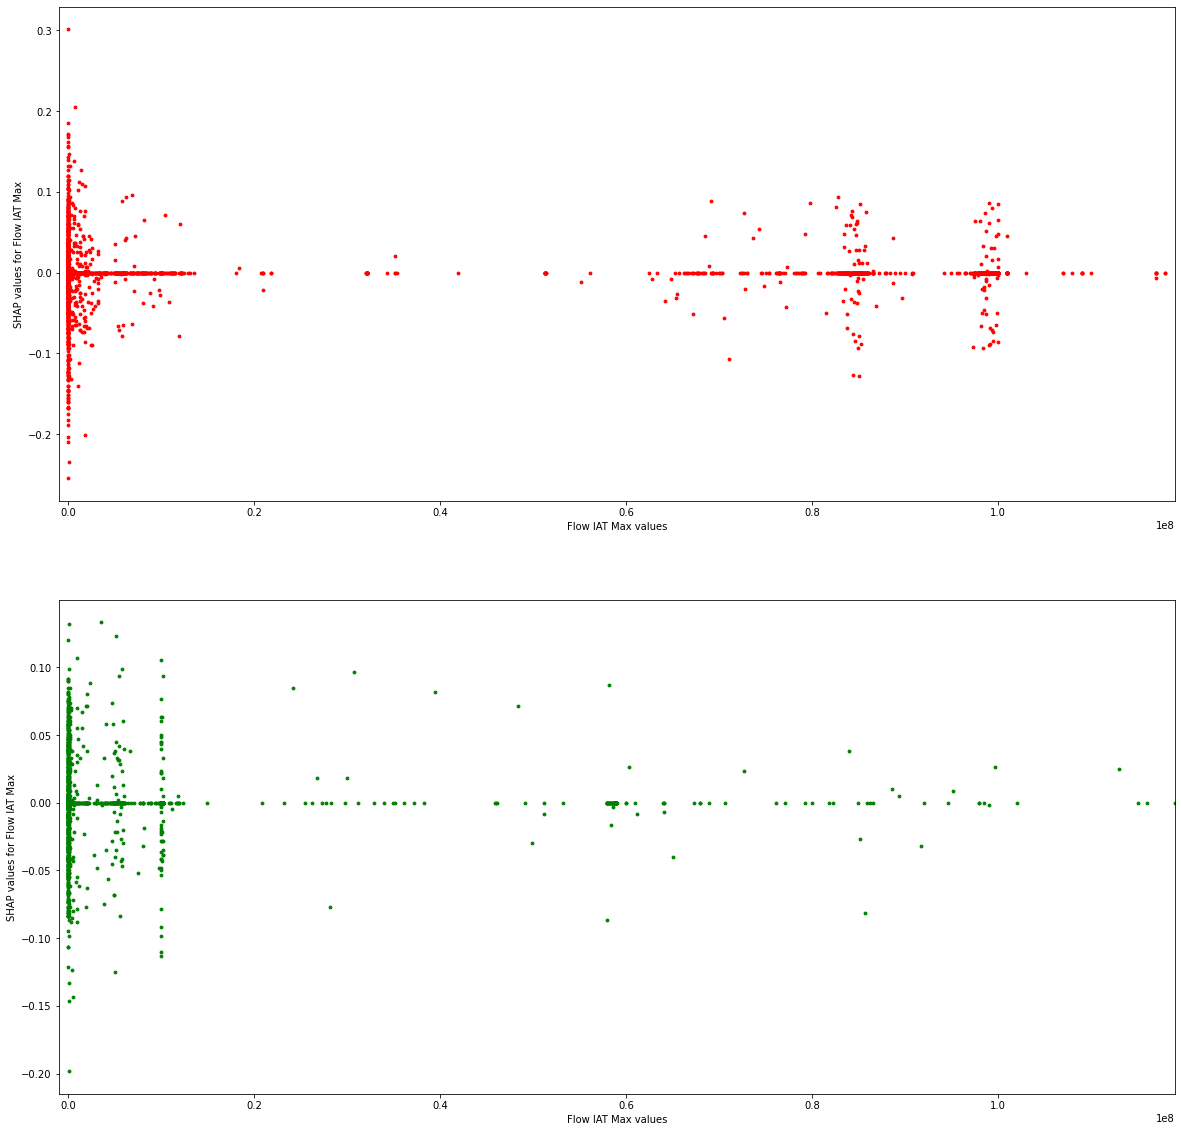

In [13]:
fig, ax = plt.subplots(2, figsize=(20, 20))
ax[0].scatter(load_shap_values[attack_indx," Flow IAT Max"].data, load_shap_values[attack_indx," Flow IAT Max"].values, color = "r", marker = "o", s = 8)
ax[0].set_xlabel("Flow IAT Max values")
ax[0].set_ylabel("SHAP values for Flow IAT Max")
ax[0].set_xlim([-1000000, max(max(load_shap_values[attack_indx," Flow IAT Max"].data), max(load_shap_values[benign_indx," Flow IAT Max"].data))+10000])

ax[1].scatter(load_shap_values[benign_indx," Flow IAT Max"].data, load_shap_values[benign_indx," Flow IAT Max"].values, color = "g", marker = "o", s = 8)
ax[1].set_xlabel("Flow IAT Max values")
ax[1].set_ylabel("SHAP values for Flow IAT Max")
ax[1].set_xlim([-1000000, max(max(load_shap_values[attack_indx," Flow IAT Max"].data), max(load_shap_values[benign_indx," Flow IAT Max"].data))+10000])

# Shap Interaction effects

In [4]:
# shap_interaction = explainer.shap_interaction_values(X)

# Pattern Discovery with DT

In [5]:
dt_df = pd.DataFrame(columns = X_test.columns)
print(dt_df.columns)

# Since we want to study pattern recognition between edge features
# We don't insert Source_IP Destination_IP and label shap values 

print(len(load_shap_values.values))
print(load_shap_values.values[0])

for i in range(len(load_shap_values.values)):
    if (i % 10000 == 0):
        print(i)
    dt_df.loc[-1] = load_shap_values.values[i]  # adding a row
    dt_df.index = dt_df.index + 1  # shifting index

print(dt_df)

Index([' Bwd IAT Std', ' Flow IAT Min', ' Total Length of Bwd Packets',
       ' Bwd Packets/s', ' Packet Length Std', ' Fwd IAT Max', ' Bwd IAT Max',
       'Bwd Packet Length Max', 'Fwd IAT Total', ' Subflow Fwd Bytes',
       'Bwd IAT Total', ' Bwd IAT Min', ' Down/Up Ratio', ' PSH Flag Count',
       ' Avg Fwd Segment Size', ' Fwd Packet Length Mean',
       'Total Length of Fwd Packets', ' Bwd Packet Length Mean',
       'Init_Win_bytes_forward', ' Flow IAT Max', ' Fwd Header Length',
       ' Total Backward Packets', ' Source IP', ' Average Packet Size',
       ' Packet Length Variance', ' Fwd IAT Std', ' Idle Min',
       ' Bwd Packet Length Std', ' Flow IAT Mean', ' Init_Win_bytes_backward',
       ' Bwd IAT Mean', ' Fwd Packet Length Std', ' Fwd IAT Mean',
       ' Flow Duration', ' Avg Bwd Segment Size', 'Subflow Fwd Packets',
       ' Bwd Header Length', ' Fwd Packet Length Min', ' Subflow Bwd Bytes',
       ' Destination IP', ' Min Packet Length', ' act_data_pkt_fwd',
     

In [6]:
dt_df_saved = dt_df

In [7]:
dt_df = dt_df.drop(' Source IP', axis=1)
dt_df = dt_df.drop(' Destination IP', axis=1)
dt_df = dt_df.drop('label', axis=1)
print(len(dt_df.columns))

53


In [8]:
dt_df.insert(loc = 0, column = 'label', value = X_test["label"])
print(len(dt_df.columns))
print(dt_df['label'])

54
9999    0.0
9998    0.0
9997    0.0
9996    0.0
9995    0.0
       ... 
4       1.0
3       1.0
2       1.0
1       1.0
0       1.0
Name: label, Length: 10000, dtype: float64


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

cols = list(set(list(dt_df.columns )) - set(list(['label'])) )

x_dt_df = dt_df[cols]
y_dt_df = dt_df['label']

X1_train, X1_test, y1_train, y1_test = train_test_split(x_dt_df, y_dt_df, test_size=0.3, random_state=123, stratify= y_dt_df)

dt_entropy = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth = 10, min_samples_leaf = 5)
# Performing training
dt_entropy.fit(X1_train, y1_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=100)

In [51]:
# Performing testing
pred = dt_entropy.predict(X1_test)

import sklearn

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(y1_test, pred))
print("Precision : ", sklearn.metrics.precision_score(y1_test, pred, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(y1_test, pred, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(y1_test, pred, labels = [0,1]))

Metrics : 
Accuracy :  0.6056666666666667
Precision :  0.6084873374401095
Recall :  0.5926666666666667
f1_score :  0.6004728132387708


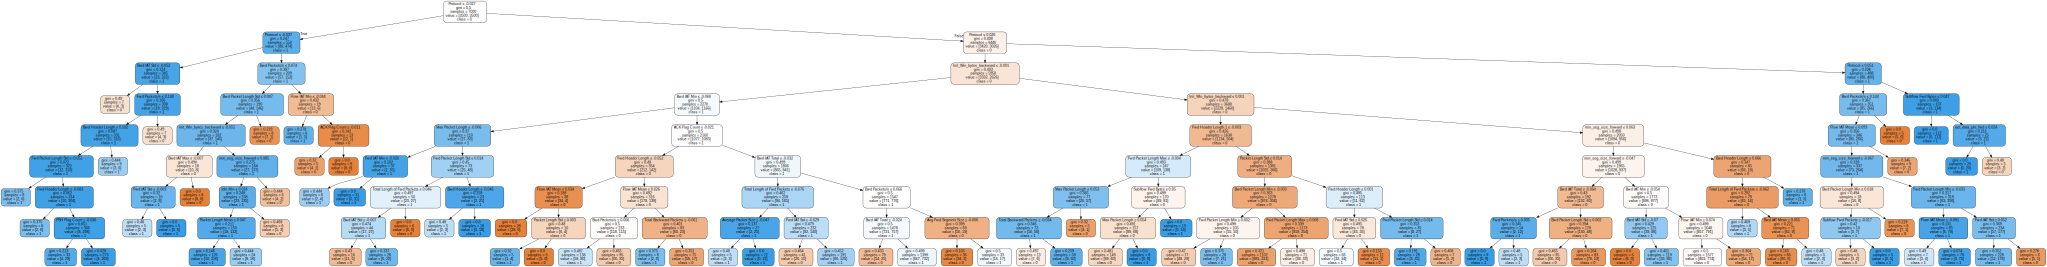

In [33]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(dt_entropy, out_file = None, feature_names = cols, class_names = ["0", "1"], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data, format="png")
graph.render("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/SHAP/DT/feature_selection_dt_entropy_depth3")
graph